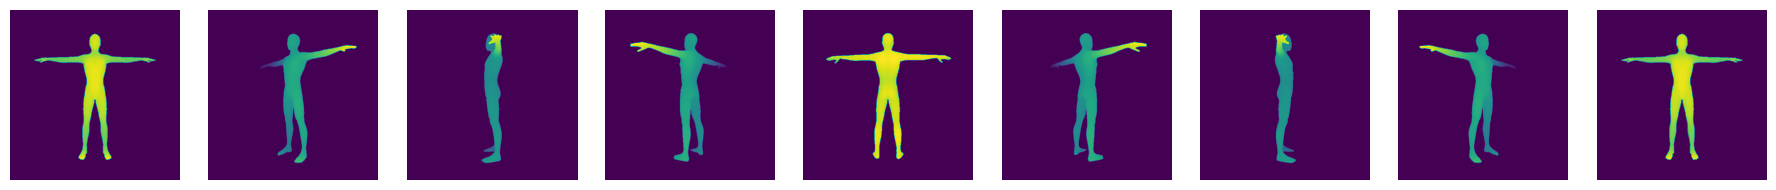

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

from text3d2video.utilities.ipython_utils import display_ims

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
import torch

torch.set_grad_enabled(False)

animation_tag = 'mixamo-human_rotation:latest'
animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)

verts_uvs, faces_uvs = animation.uv_data()

n_frames = 9
frame_indices = animation.frame_indices(9)
cameras, meshes = animation.load_frames(frame_indices)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

In [2]:
from text3d2video.backprojection import project_visible_texels_to_camera

texture_res = 64

frame_projections = []
for render_cams, render_meshes in zip(cameras, meshes):
    proj = project_visible_texels_to_camera(
        render_meshes, render_cams, verts_uvs, faces_uvs, texture_res
    )
    frame_projections.append(proj)

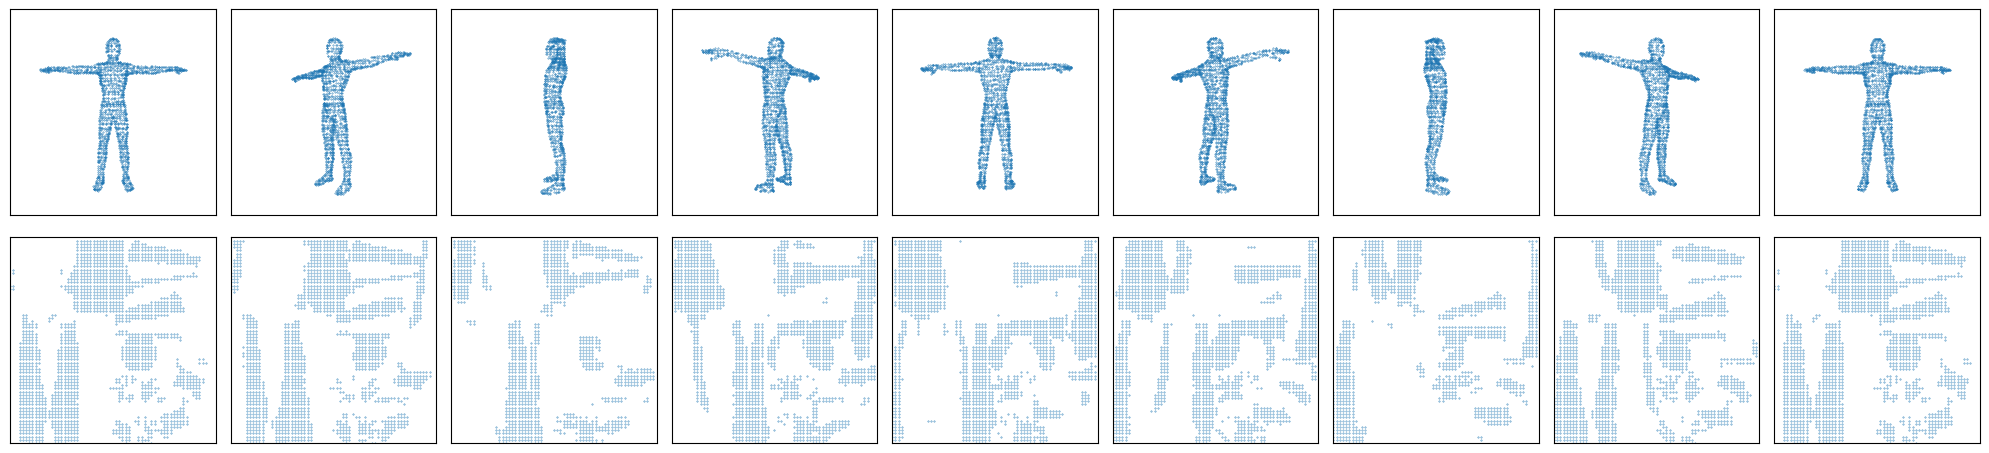

In [3]:
from matplotlib import pyplot as plt

s = 0.1

fig, axs = plt.subplots(2, len(meshes), figsize=(20, 5))

for i, proj in enumerate(frame_projections):
    ax_cam = axs[0, i]
    ax_uv = axs[1, i]

    xys = proj.xys
    uvs = proj.uvs

    ax_cam.scatter(xys[:, 0].cpu(), xys[:, 1].cpu(), s=s)
    ax_uv.scatter(uvs[:, 0].cpu(), uvs[:, 1].cpu(), s=s)

    ax_uv.set_aspect("equal")
    ax_uv.set_xlim(0, texture_res)
    ax_uv.set_ylim(0, texture_res)

    ax_cam.set_xlim(-1, 1)
    ax_cam.set_ylim(-1, 1)
    ax_cam.set_aspect("equal")

    ax_uv.set_xticks([])
    ax_uv.set_yticks([])
    ax_cam.set_xticks([])
    ax_cam.set_yticks([])

plt.tight_layout()

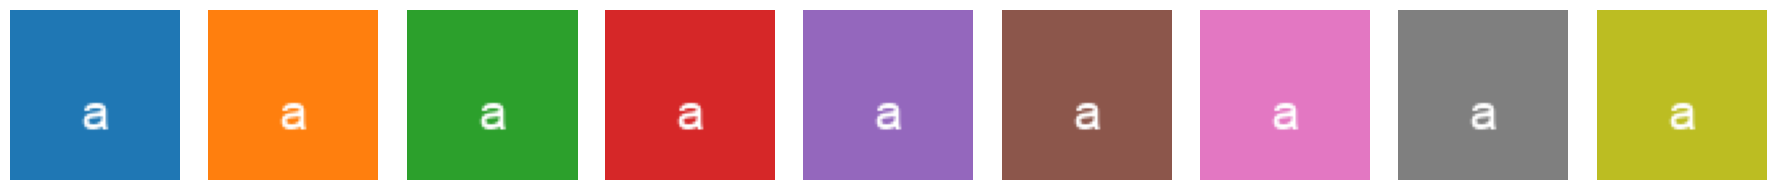

In [4]:
from matplotlib.cm import get_cmap
from text3d2video.utilities.testing_utils import test_img
import torchvision.transforms.functional as TF

CAMERA_RES = 64
cmap = get_cmap("tab10")

indices = torch.arange(n_frames)
colors = cmap(indices)

features_cond = [
    test_img(resolution=CAMERA_RES, color=colors[i][0:3], txt="a")
    for i in range(n_frames)
]
feature_maps = torch.stack([TF.to_tensor(img) for img in features_cond])

display_ims(features_cond)

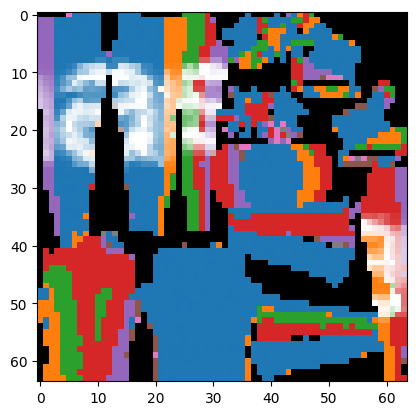

In [6]:
# frame_xy_coords
# frame_uv_coords

from text3d2video.backprojection import aggregate_views_uv_texture

xys = [proj.xys.cpu() for proj in frame_projections]
uvs = [proj.uvs.cpu() for proj in frame_projections]

uv_map = aggregate_views_uv_texture(
    feature_maps,
    texture_res,
    xys,
    uvs,
)

plt.imshow(uv_map.cpu())
